# COURSE: A deep understanding of deep learning
## SECTION: ANNs
### LECTURE: Multi-output ANN (iris dataset)
#### TEACHER: Mike X Cohen, sincxpress.com
##### COURSE URL: udemy.com/course/deeplearning_x/?couponCode=202305

In [1]:

import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
# import libraries
import torch
import torch.nn as nn

matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [2]:
# use the GPU if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


# Import and process the data

In [3]:
# import dataset (comes with seaborn)
import seaborn as sns

iris = sns.load_dataset('iris')

# check out the first few lines of data
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


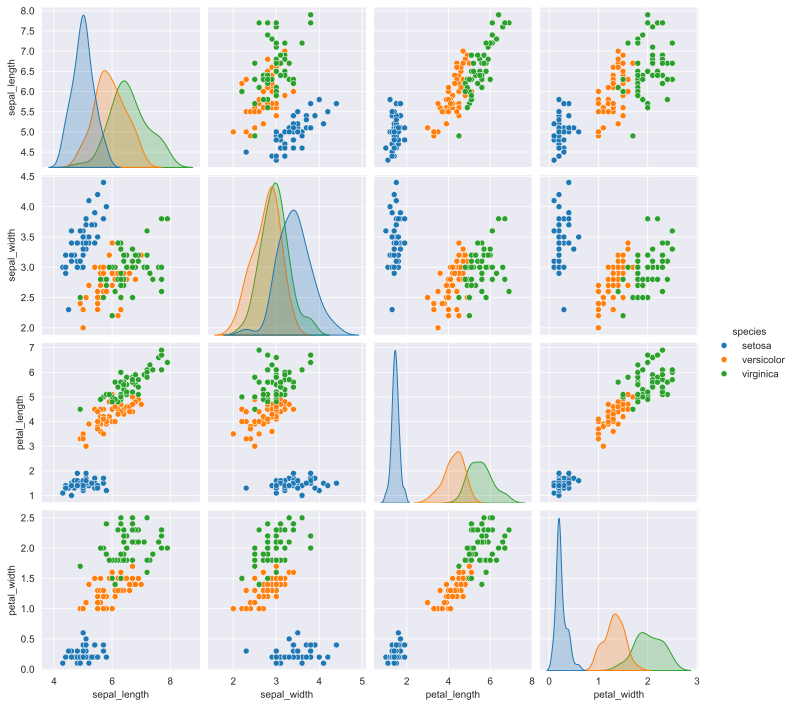

In [4]:
# some plots to show the data
sns.pairplot(iris, hue='species')
plt.show()

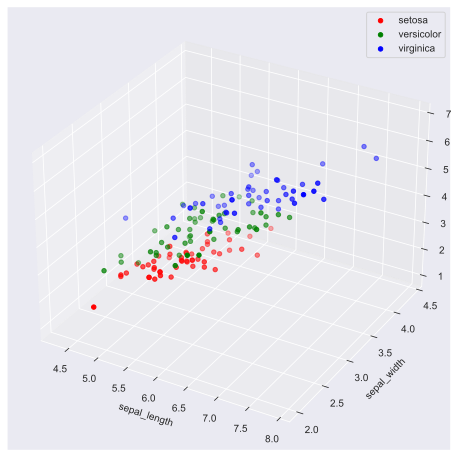

In [5]:
# plot the dataset in 3D, using the first three features and color-coded by species

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

colors = ['r', 'g', 'b']
for i in range(3):
    # ax.scatter(iris.iloc[iris.species==iris.species.unique()[i],0],
    #            iris.iloc[iris.species==iris.species.unique()[i],1],
    #            iris.iloc[iris.species==iris.species.unique()[i],2],
    #            c=colors[i],label=iris.species.unique()[i])
    # NotImplementedError: iLocation based boolean indexing on an integer type is not available
    ax.scatter(iris[iris.species == iris.species.unique()[i]].iloc[:, 0],
               iris[iris.species == iris.species.unique()[i]].iloc[:, 1],
               iris[iris.species == iris.species.unique()[i]].iloc[:, 2],
               c=colors[i], label=iris.species.unique()[i])

ax.set_xlabel(iris.columns[0])
ax.set_ylabel(iris.columns[1])
ax.set_zlabel(iris.columns[2])
ax.legend()
plt.show()

In [6]:
# organize the data

# convert from pandas dataframe to tensor
data = torch.tensor(iris[iris.columns[0:4]].values).float()

# transform species to number
labels = torch.zeros(len(data), dtype=torch.long)
# labels[iris.species=='setosa'] = 0 # don't need!
labels[iris.species == 'versicolor'] = 1
labels[iris.species == 'virginica'] = 2

print(f"labels: {labels}")
print(f"shape of labels: {labels.shape}")

labels: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2])
shape of labels: torch.Size([150])


# Create the ANN model

In [7]:
# model architecture

units_per_layer = 64

ANNiris = nn.Sequential(
    nn.Linear(4, units_per_layer),  # input layer
    nn.ReLU(),  # activation
    nn.Linear(units_per_layer, units_per_layer),  # hidden layer
    nn.ReLU(),  # activation
    nn.Linear(units_per_layer, 3),  # output layer
    # nn.Softmax(dim=1)  # final activation  --> not needed for the loss function we're using (see below) 
)

# loss function
lossfun = nn.CrossEntropyLoss()  # includes logSoftmax and the NLLLoss (negative log likelihood)

# optimizer (Stochastic Gradient Descent, with a small learning rate)
optimizer = torch.optim.SGD(ANNiris.parameters(), lr=.01)
ANNiris

Sequential(
  (0): Linear(in_features=4, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=3, bias=True)
)

## Parameters in the model
(4 * 64) + 64 + (64 * 64) + 64 + (64 * 3) + 3 = 
256 + 64 + 4096 + 64 + 192 + 3 = **4675 parms**


![image](irisann.png)


# Train the model

In [8]:
numepochs = 2500

# TO use the GPU, send the model and data to the GPU:
ANNiris.to(device)
data = data.to(device)
labels = labels.to(device)

# initialize losses
losses = torch.zeros(numepochs)
losses_per_class = torch.zeros(numepochs, 3)

ongoingAcc = []
ongoingAcc_per_class = torch.zeros(numepochs, 3)

# preset yHat with zeros
yHat = torch.zeros(labels.shape[0], 3)  # yHat is hot-encoded (one column per output = 3 columns)

# loop over epochs
for epochi in range(numepochs):
    # forward pass
    yHat = ANNiris(data)

    # compute loss
    loss = lossfun(yHat, labels)  # shapes are: yHat=(150,3), labels=(150) 

    # store loss for later plotting (not part of the training process)
    losses[epochi] = loss  # loss is a scalar tensor. We need to extract the scalar value using .item()
    
    # compute loss for each class
    for i in range(3):
        # losses_per_class[epochi, i] = lossfun(yHat, labels == i)
        # "nll_loss_forward_reduce_cuda_kernel_2d_index" not implemented for 'Bool'
        losses_per_class[epochi, i] = lossfun(yHat[labels == i], labels[labels == i])

    # backprop (a general method of all pytorch tensors, not exclusive to model parameters)
    optimizer.zero_grad()  # reset gradients
    loss.backward()  # backward is a method of the loss tensor. It computes dLoss/dx for every parameter x
    optimizer.step()  # update weights

    # compute accuracy at each training epoch (not part of the training process, just for plotting later)
    matches = torch.argmax(yHat, axis=1) == labels  # booleans (false/true)
    matchesNumeric = matches.float()  # convert to numbers (0/1)
    accuracyPct = 100 * torch.mean(matchesNumeric)  # average and x100 
    ongoingAcc.append(accuracyPct)  # add to list of accuracies
    
    # compute accuracy for each class
    classAcc = torch.zeros(3)
    for i in range(3):
        classAcc[i] = 100 * torch.mean((torch.argmax(yHat, axis=1) == labels)[labels == i].float())
    
    ongoingAcc_per_class[epochi, :] = classAcc
        

# run a final forward pass and compute accuracy
yHat = ANNiris(data)
print(f"prediction tensor:\n{yHat[-10:]}")
predlabels = torch.argmax(yHat, axis=1)
print(f"predicted labels: {predlabels[-10:]}\ntrue labels: {labels[-10:]}")
matchesNumeric = (predlabels == labels)
print("matches: ", ['match' if i else 'no match' for i in matchesNumeric[-10:]])

# convert matchesNumeric to float and take the mean
totalacc = 100 * torch.mean(matchesNumeric.float())
print(f"total accuracy: {totalacc:.2f}%")


prediction tensor:
tensor([[-9.5475,  3.5783, 10.8756],
        [-6.9144,  4.5610,  7.0026],
        [-8.0395,  3.3485,  8.9878],
        [-9.8663,  3.6674, 11.2504],
        [-9.8304,  3.5282, 11.3157],
        [-7.8678,  4.0739,  8.4516],
        [-7.3717,  3.8799,  7.7938],
        [-6.9545,  4.3289,  7.1497],
        [-8.4079,  3.6645,  9.4690],
        [-6.7071,  3.9989,  7.0195]], device='cuda:0',
       grad_fn=<SliceBackward0>)
predicted labels: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2], device='cuda:0')
true labels: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2], device='cuda:0')
matches:  ['match', 'match', 'match', 'match', 'match', 'match', 'match', 'match', 'match', 'match']
total accuracy: 97.33%


## Note about The **backward()** method

The **backward()** method can be applied to any torch.Tensor object, but only if the tensor is a scalar 
(i.e., it contains a single value) or if you provide a gradient argument that matches the tensor's shape. 


The backward() method computes the gradient of the tensor with respect to some scalar value, 
typically a loss function in the context of neural networks.  

Here is an example:

```python
# Create a tensor
x = torch.tensor(2.0, requires_grad=True)

# Perform some operations
y = x ** 2

# Compute the gradient
y.backward()

# Print the gradient
print(x.grad)  # Output: tensor(4.)
```

# Visualize the results

Final accuracy: 97.3333%
Final accuracy for each class:
setosa: 100.00%
versicolor: 94.00%
virginica: 98.00%


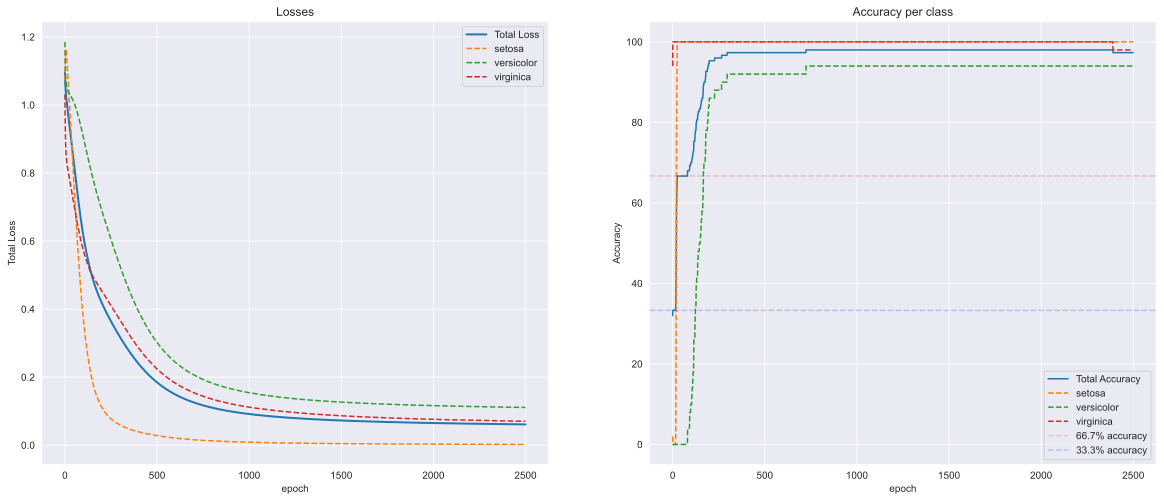

In [9]:
# report accuracy
print('Final accuracy: %g%%' % totalacc)

# final accuracy for each class
print('Final accuracy for each class:')
for i in range(3):
    print(f'{iris.species.unique()[i]}: {ongoingAcc_per_class[-1, i]:.2f}%')
    
fig, ax = plt.subplots(1, 2, figsize=(20, 8))

ax[0].plot(losses.detach(), label='Total Loss', linewidth=2)
ax[0].set_ylabel('Total Loss')
ax[0].set_xlabel('epoch')
ax[0].set_title('Losses')

# plot the loss for each class
ax[0].plot(losses_per_class.detach(), linestyle='--', label=iris.species.unique())
ax[0].legend()


# copy the tensor to host memory first
# ongoingAcc = torch.tensor(ongoingAcc).detach()
# ongoingAcc_per_class = ongoingAcc_per_class.detach()
# UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
ongoingAcc = torch.tensor(ongoingAcc).clone().detach()
ongoingAcc_per_class = ongoingAcc_per_class.clone().detach()

ax[1].plot(ongoingAcc, label='Total Accuracy')
ax[1].set_ylabel('Total accuracy')
ax[1].set_xlabel('epoch')
ax[1].set_title('Accuracy')

# plot the accuracy for each class
ax[1].plot(ongoingAcc_per_class, label=iris.species.unique(), linestyle='--')
ax[1].set_ylabel('Accuracy')
ax[1].set_xlabel('epoch')
ax[1].set_title('Accuracy per class')
ax[1].legend()

# set y range from 0 to 100
# ax[1].set_ylim([0, 100])

# a horizontal line at 66.7% accuracy. Set opacity to 0.5
ax[1].axhline(66.7, color='red', linestyle='--', label='66.7% accuracy',
              alpha=.2)  # 1/3 chance level, the model has learned just 2/3 of the classes
# a horizontal line at 33.3% accuracy. Set opacity to 0.5
ax[1].axhline(33.3, color='blue', linestyle='--', label='33.3% accuracy',
              alpha=.2)  # 1/3 chance level, the model has learned just 1/3 of the classes
ax[1].legend()

plt.show()
# run training again to see whether this performance is consistent

In [10]:
# confirm that all model predictions sum to 1, but only when converted to softmax
sm = nn.Softmax(1)
torch.sum(sm(yHat), axis=1)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 

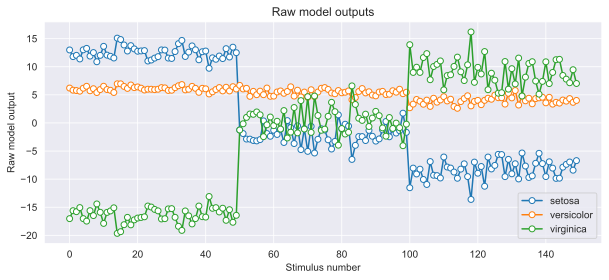

In [11]:
# plot the raw model outputs

fig = plt.figure(figsize=(10, 4))

# set title
plt.title('Raw model outputs')

# copy the tensor to host memory first
yHat = yHat.detach()
# Use Tensor.cpu() to copy the tensor to host memory first.
plt.plot(yHat.cpu(), 'o-', markerfacecolor='w')

# plt.plot(yHat.detach(),'o-',markerfacecolor='w')
plt.xlabel('Stimulus number')
plt.ylabel('Raw model output')
plt.legend(['setosa', 'versicolor', 'virginica'])
plt.show()

# try it again without the softmax!

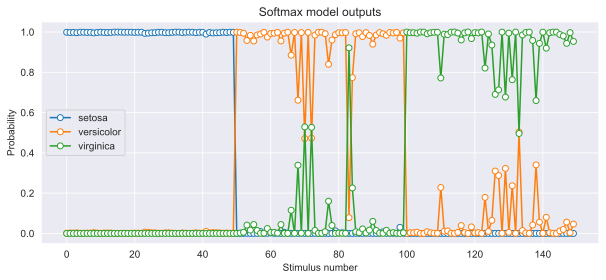

In [12]:
# plot the softmax model outputs

fig = plt.figure(figsize=(10, 4))
# set title
plt.title('Softmax model outputs')
# Use Tensor.cpu() to copy the tensor to host memory first.
plt.plot(sm(yHat).cpu(), 'o-', markerfacecolor='w')
# plt.plot(sm(yHat).detach(),'o-',markerfacecolor='w')
plt.xlabel('Stimulus number')
plt.ylabel('Probability')
plt.legend(['setosa', 'versicolor', 'virginica'])
plt.show()

# Additional explorations

In [13]:
# 1) When the loss does not reach an asymptote, it's a good idea to train the model for more epochs. Increase the number of
#    epochs until the plot of the losses seems to hit a "floor" (that's a statistical term for being as small as possible).
# 
# 2) We used a model with 64 hidden units. Modify the code to have 16 hidden units. How does this model perform? If there
#    is a decrease in accuracy, is that decrease distributed across all three iris types, or does the model learn some
#    iris types and not others?
# 
# 3) Write code to compute three accuracy scores, one for each iris type. In real DL projects, category-specific accuracies
#    are often more informative than the aggregated accuracy.
# 